# MoveNet을 이용한 Pose 추정

- Google Research에서 공개한 pose 추정 모델.
- 데스크탑, 노트북, 휴대폰 등의 일반적인 환경에서도 좋은 속도와 성능을 내는 것을 특징으로 한다.
- 다음 두가지 버전의 모델을 제공
    - Thunder: 높은 정확도를 필요로하는 application을 위한 모델
    - Lightning: 처리시간(빠른 처리)이 중요한 application을 위한 모델
- 또한 single pose 모델과 multi pose 모델을 제공한다.
    - multipose 모델은 최대 6명까지 검출한다.
    
- 모든 모델은 Tensorflow hub를 통해 제공한다.
    - Tensorflow 버전, TFLite 버전, Tensorflow.js 버전을 제공한다.
- [Tutorial](https://www.tensorflow.org/hub/tutorials/movenet)
- [라이브데모](https://storage.googleapis.com/tfjs-models/demos/pose-detection/index.html?model=movenet)
    
> ## Tensorflow hub
> 
> Tensorflow hub는 각 분야의 미리학습된 모델들의 저장소이다. 
> 서비스를 위한 완성된 모델이나 transfer learning을 위한 모델에 tensorflow hub에서 제공하는 모델을 간단한 코드 몇줄로 쉽게 적용할 수 있다.
> 
> - https://www.tensorflow.org/hub/tutorials?hl=ko
> - 모델 검색: https://tfhub.dev/

In [1]:
# tensorflow hub 설치
!pip install tensorflow-hub

     -------------------------------------- 108.8/108.8 kB 3.2 MB/s eta 0:00:00


## MoveNet 출력 Keypoints

- 추론결과: 17개의 keypoint를 출력한다. 각 keypoint는 (**Y**좌표, **X**좌표, confidence score) 3개의 값으로 구성된다.
    - singlepose의 경우 (17, 3) 으로 구성된다. 

<center><span style="font-size:large;font-weight:bold">17개 keypoints index</span></center>

<b>
    
|<span style="font-size:medium;">index</span>|<span style="font-size:medium;">위치</span>
|-|-
|0|nose
|1|left eye
|2|right eye
|3|left ear
|4|right ear
|5|left shoulder
|6|right shoulder
|7|left elbow
|8|right elbow
|9|left wrist
|10|right wrist
|11|left hip
|12|right hip
|13|left knee
|14|right knee
|15|left ankle
|16|right ankle
    
</b>
    


# 구현

In [3]:
import tensorflow as tf
import tensorflow_hub as hub

import cv2
import numpy as np
import matplotlib.pyplot as plt

## 모델 로딩

In [6]:
# 모델을 Tensorflow hub로부터 다운로드 해서 메모리로 로딩
model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
print(type(model)) # 여러 모델들을 담고있는 객체

<class 'tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject'>


In [7]:
model.signatures # 여러보들이 key- 모델 형태로 저장됨. 이것을 확인 (이름- 모델: signatured)

_SignatureMap({'serving_default': <ConcreteFunction signature_wrapper(*, input) at 0x18D03E540A0>})

In [8]:
movenet = model.signatures['serving_default'] # 모델을 조회
print(type(movenet))

<class 'tensorflow.python.saved_model.load._WrapperFunction'>


## 추론할 이미지 로딩및 전처리
- 이미지를 모델에 맞게 resize한다.
    - thunder: 256, 256
    - lightning: 192, 192
- 타입: int32

In [10]:
# 추론할 이미지 로딩 + 전처리 (resize: 256 X 256, int32 타입)
image_path = 'test_image/babel1.jpg'

image_orig = cv2.imread(image_path)
print(image_orig.shape)
cv2.imshow('frame', image_orig)
cv2.waitKey(0)
cv2.destroyAllWindows()

(562, 356, 3)


In [16]:
# BGR -> RGB + batch axis 추가
input_tensor = cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)[np.newaxis, ...]
# resize : thunder - 256 X 256
input_tensor = tf.image.resize_with_pad(input_tensor, 192, 192) # 원본 이미지의 종횡비를 유지하면서 resize
# int32 로 형변환
input_tensor = tf.cast(input_tensor, dtype=tf.int32)

print("원본 크기, dtype:", image_orig.shape, image_orig.dtype)
print("input tensor 크기, dtype:", input_tensor.shape, input_tensor.dtype)

원본 크기, dtype: (562, 356, 3) uint8
input tensor 크기, dtype: (1, 192, 192, 3) <dtype: 'int32'>


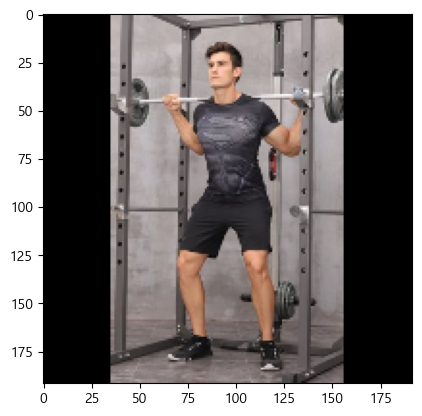

In [17]:
plt.imshow(input_tensor.numpy()[0].astype('uint8'));

## 추론 및 결과 조회

In [18]:
outputs = movenet(input_tensor)
print(type(outputs))

<class 'dict'>


In [20]:
outputs.keys()

dict_keys(['output_0'])

In [21]:
keypoints = outputs['output_0']
print(type(keypoints), keypoints.shape)
# (1:이미지 개수, 1:사람수, 17:keypoint개수, 3:yxc)

<class 'tensorflow.python.framework.ops.EagerTensor'> (1, 1, 17, 3)


In [22]:
nose_kp = keypoints[0, 0, 0] # 코의 keypoint
nose_kp

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.15304059, 0.45321697, 0.7357648 ], dtype=float32)>

In [23]:
nose_y = nose_kp[0] * image_orig.shape[0]
nose_x = nose_kp[1] * image_orig.shape[1]
nose_conf = nose_kp[2]
print(nose_y.numpy(), nose_x.numpy(), nose_conf.numpy())

86.00881 161.34525 0.7357648


## 추론한 keypoint 원본 영상에 표시
- keypoints: 찾은 관절표시
- edge: 관절 연결

In [24]:
# 연결할 keypoint들을 튜플로 묶은 것
# (0, 1) - 0번과 1번 keypoint들을 연결
EDGE_LINK = [
    (0, 1),
    (0, 2),
    (1, 3),
    (2, 4),
    (0, 5),
    (0, 6),
    (5, 7),
    (7, 9),
    (6, 8),
    (8, 10),
    (5, 6),
    (5, 11),
    (6, 12),
    (11, 12),
    (11, 13),
    (13, 15),
    (12, 14),
    (14, 16)
]

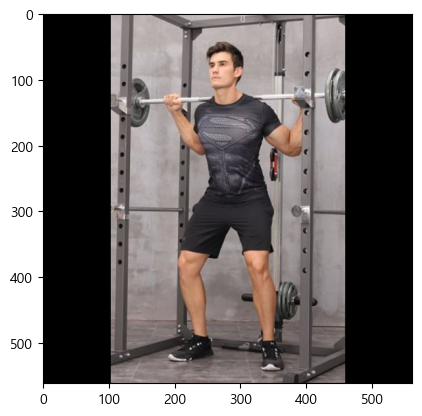

In [29]:
h, w, _ = image_orig.shape
h = w = max(h, w) # 원본 이미지의 height와 width를 큰 쪽으로 통일 -> 추론할 때 width와 height가 같은 크기로 추론했기 때문에 맞춰준다.

frame = cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)
frame = tf.image.resize_with_pad(frame, h, w).numpy().astype('uint8') # (256, 256) ==> (562, 562)
plt.imshow(frame);

In [30]:
keypoints.numpy().squeeze() * np.array([h, w, 1])

array([[8.60088104e+01, 2.54707937e+02, 7.35764802e-01],
       [7.89606199e+01, 2.69276755e+02, 7.24450529e-01],
       [7.83862329e+01, 2.52630085e+02, 7.61560440e-01],
       [8.77512325e+01, 2.96349601e+02, 8.59300137e-01],
       [8.65661805e+01, 2.61974751e+02, 8.12272489e-01],
       [1.37192661e+02, 3.28406905e+02, 8.22631538e-01],
       [1.44908647e+02, 2.40082224e+02, 8.83804142e-01],
       [2.01746258e+02, 3.75296303e+02, 8.06884706e-01],
       [2.10998939e+02, 2.31718524e+02, 6.85711980e-01],
       [1.56980186e+02, 3.85662703e+02, 4.02850628e-01],
       [1.54804201e+02, 1.98015305e+02, 6.59525752e-01],
       [2.79648749e+02, 3.14436811e+02, 8.37013066e-01],
       [2.79349362e+02, 2.59363027e+02, 8.83521914e-01],
       [3.91122846e+02, 3.24045323e+02, 8.86515021e-01],
       [3.85286455e+02, 2.17640098e+02, 7.63097823e-01],
       [5.02200747e+02, 3.42172395e+02, 8.36578727e-01],
       [4.96139654e+02, 2.37134936e+02, 9.00774658e-01]])

In [31]:
# keypoint들을 표시
score_threshold = 0.3  # 지정한 confidence score 이상인 keypoint들만 출력
denormalized_keypoints = keypoints.numpy().squeeze() * np.array([h, w, 1])

for kp_y, kp_x, kp_score in denormalized_keypoints:  # keypoint 좌표의 점(원)을 찍기
    if kp_score >= score_threshold:
        cv2.circle(frame, center=(int(kp_x), int(kp_y)), radius = 3, color=[255,255,0], thickness=-1, # 색채우기
                  lineType = cv2.LINE_AA)

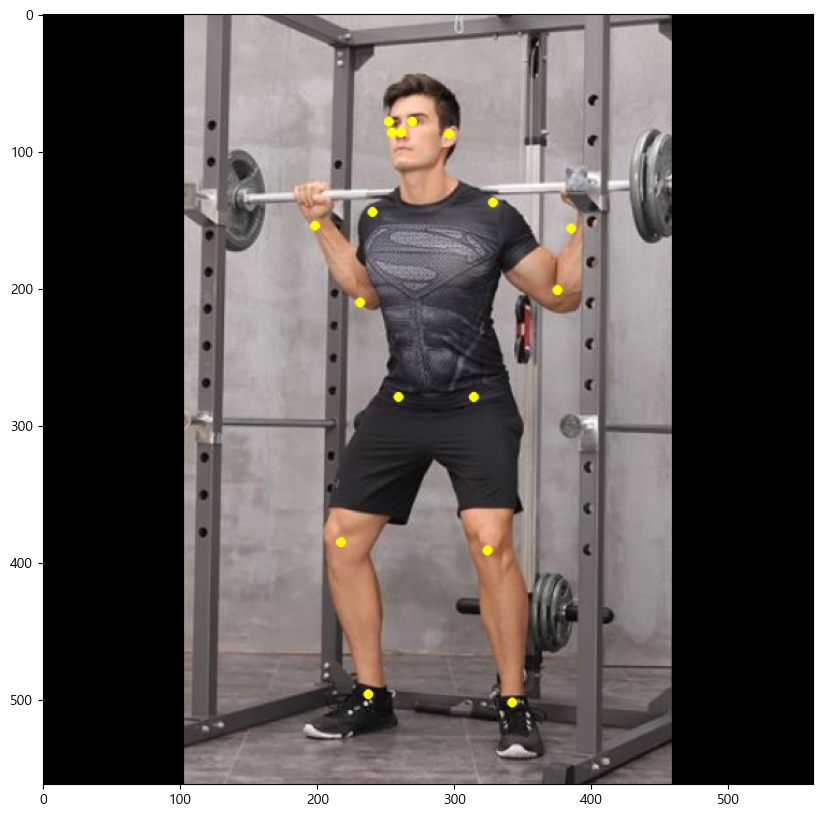

In [32]:
plt.figure(figsize=(10, 10))
plt.imshow(frame);

In [37]:
# Edge를 출력 ->  Edge: keypoint간의 연결선  # EDGE_LINK 리스트를 이용
for edge in EDGE_LINK:
    p1, p2 = edge
    y1, x1, score1 = denormalized_keypoints[p1]
    y2, x2, score2 = denormalized_keypoints[p2]
    y1, x1, y2, x2 = int(y1), int(x1), int(y2), int(x2) # 좌표를 정수로 변환
    # 두 keypoint의 confidence score가 threshold 이상이면 그린다.
    if score1 >= score_threshold and score2 >= score_threshold:
        cv2.line(frame, pt1=(x1, y1), pt2=(x2, y2), color =[0, 255, 255], thickness = 1, lineType=cv2.LINE_AA)

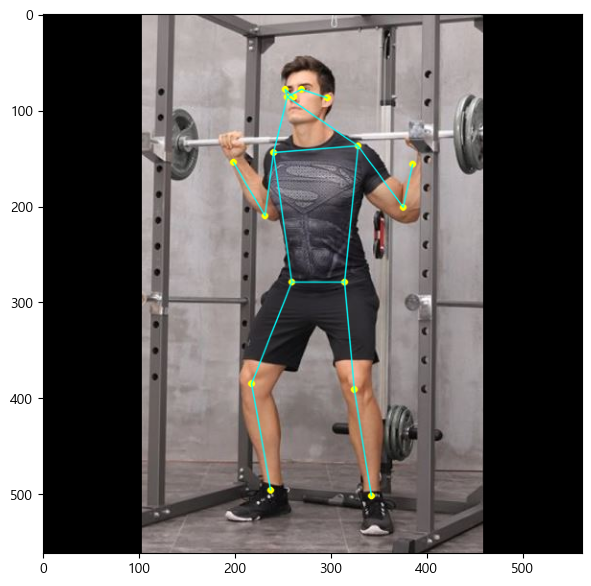

In [38]:
plt.figure(figsize=(7, 7))
plt.imshow(frame)
plt.show()